## Imports

In [119]:
import os
os.environ["CUDA_VISIBLE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
# import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

In [120]:
import librosa

Setting the number of files in the training set. The max_length parameter below is used to capture the maximum length of time domain across all the train, test and validation signals. This parameter is used to pad all my signals with zeros up to the max_length. Sampling rate of all signals in 22kHz. (setting sr to 22kHz gives blank output)

## Loading files

In [121]:
#No. of files

n_file = 310

max_length = 350

sr = 48000 

The following function loads all the files and computes STFT for all those loaded signals, gets the absolute values, and the lengths of all the signals. 

In [122]:
#Loading the file, performing STFT, taking absolute, padding zeros as required

def loadfile(path,extension, str_tr, flag = 0):
    list_tr = []
    list_stft = []
    list_stft_abs = []
    list_length = []
    z = ['000', '00', '0', '']
    
    for i in range(n_file):
        if (i == 0):
            j = 0
        else:
            j = int(math.log10(i))
        s, sr = librosa.load(path + str(i+1) + extension, sr = None)
        if (flag == 1):
            list_tr.append(s)
        
        #Calculating STFT
        stft = librosa.stft(s, n_fft= 1024, hop_length= 512)
        
        stft_len = stft.shape[1]
        
        #Appending STFT to list
        if (flag == 1):
            list_stft.append(stft)
        
        #Calculating Absolute of STFT
        stft_abs = np.abs(stft)
        
        #Padding zeros
        stft_abs = np.pad(stft_abs, ((0,0),(0, max_length-stft_len)), 'constant')
        
        #Appending abs to list
        list_stft_abs.append(stft_abs)
        stft_len = stft_abs.shape[1]
        
        #Appending time-length of STFT to list
        list_length.append(stft_len)
        
    return list_tr, list_stft, list_stft_abs, list_length

Setting the path to load the training signals

In [123]:
#Path of the training signals
path = r'/home/mangdy/Desktop/'

In [124]:
#Loading all training noisy speech signals

trx, X, X_abs, X_len = loadfile(path+"/trimmed_noisy/",'.wav', 'trx')

#Loading all training clean speech signals

trs, S, S_abs, S_len = loadfile(path+"/trimmed_clean/",'.wav', 'trs')

#Loading all training noise signals

trn, N, N_abs, N_len = loadfile(path+"/gauss_noise/", '.wav', 'trn')

## Ideal Binary Mask

The function below computes the IBM, given the absolute valued STFTs of the clean speech and the corresponding noise signals, and returns a list of the IBMs.

In [125]:
def IBM(S, N):
    M = []
    
    for i in range(len(S)):
        m_ibm = 1 * (S[i] > N[i])
        M.append(m_ibm)
    
    return M

Fetching IBMs for the training Speech and Noise signals. These serve as the ground truth for the training of the network.

In [126]:
#Getting Binary Masks from S_abs and N_abs
M = IBM(S_abs, N_abs)

In [127]:
#For drop outs
batch_size = 10

#Keep probability for dropouts
tf.compat.v1.disable_eager_execution()
keep_pr = tf.compat.v1.placeholder(tf.float32, ())

Defining frame size = nfft/2+1. seq_len takes in the length of time domain for all the signals that would be passed in one batch. This was done to support the padding we had done earlier.

In [128]:
#Placeholders for input to the network

frame_size = 513
num_hidden = 256
seq_len = tf.compat.v1.placeholder(tf.int32, None)

q2_x = tf.compat.v1.placeholder(tf.float32, [None, max_length, frame_size])
q2_y = tf.compat.v1.placeholder(tf.float32, [None, max_length, frame_size])


## Model

Defining the RNN below. RNN with LSTM Cell with 256 hidden layers, whose weights are initialized with Xavier.
Note the 'dim' variable. It stores the length of time domain of the inputs in the training batch.

In [129]:
# Define LSTM cell with Xavier initializer and dropout wrapper
with tf.compat.v1.variable_scope("rnn", reuse=tf.compat.v1.AUTO_REUSE):
    lstm_cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(tf.compat.v1.nn.rnn_cell.LSTMCell(num_hidden,
                                                         initializer = tf.compat.v1.initializers.glorot_uniform()),
                                                         output_keep_prob = keep_pr)

    # Run dynamic RNN
    output, state = tf.compat.v1.nn.dynamic_rnn(lstm_cell, q2_x, dtype=tf.float32, sequence_length=seq_len)


rnn_out = tf.keras.layers.Dense(513, kernel_initializer= tf.compat.v1.initializers.glorot_uniform())
runn_out_output = rnn_out(output)
dim = seq_len[0]

fin_out = tf.sigmoid(runn_out_output)

/tmp/ipykernel_7577/686899163.py:3: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(tf.compat.v1.nn.rnn_cell.LSTMCell(num_hidden,


Defining learning rate below

In [130]:
lr = 0.001

Using MSE as the loss function.

In [131]:
cost = tf.reduce_mean(tf.losses.mean_squared_error(fin_out[:, :dim,:], q2_y[:, :dim, :]))
with tf.compat.v1.variable_scope('rnn', reuse=tf.compat.v1.AUTO_REUSE):
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(cost)

Intitializing the session and a saver

In [132]:
#Init all TF vars and run the session
sess = tf.compat.v1.Session()

saver = tf.compat.v1.train.Saver()

sess.run(tf.compat.v1.global_variables_initializer())

In [135]:
epochs = 50
error = np.zeros(epochs)

In [136]:
#Training the network with shuffling of training batches


for epoch in range(epochs):
    random = np.arange(0, 310, 10)
    np.random.shuffle(random)
    for i in range(len(random)):
        start = int(random[i])
        end = int(start + batch_size)
        epoch_y = np.array(M[start:end]).swapaxes(1,2)
        epoch_x = np.array(X_abs[start:end]).swapaxes(1,2)
        seqlen = np.array(X_len[start:end])
        l, _ = sess.run([cost, optimizer], feed_dict = {q2_x: epoch_x, q2_y: epoch_y, seq_len: seqlen, keep_pr: 1})
        error[epoch] += l
    
    print('Epoch', epoch+1, 'completed out of ', epochs,'; loss: ', error[epoch])

Epoch 1 completed out of  50 ; loss:  1.660012148320675
Epoch 2 completed out of  50 ; loss:  1.0520233903080225
Epoch 3 completed out of  50 ; loss:  1.037770178169012
Epoch 4 completed out of  50 ; loss:  1.0036471616476774
Epoch 5 completed out of  50 ; loss:  0.9639721643179655
Epoch 6 completed out of  50 ; loss:  0.9741082582622766
Epoch 7 completed out of  50 ; loss:  0.9689301438629627
Epoch 8 completed out of  50 ; loss:  0.922834599390626
Epoch 9 completed out of  50 ; loss:  0.9728461466729641
Epoch 10 completed out of  50 ; loss:  0.933460894972086
Epoch 11 completed out of  50 ; loss:  0.9208441246300936
Epoch 12 completed out of  50 ; loss:  0.9106425698846579
Epoch 13 completed out of  50 ; loss:  0.9112804513424635
Epoch 14 completed out of  50 ; loss:  0.9227203261107206
Epoch 15 completed out of  50 ; loss:  0.9033140018582344
Epoch 16 completed out of  50 ; loss:  0.8973166644573212
Epoch 17 completed out of  50 ; loss:  0.9095535445958376
Epoch 18 completed out of  

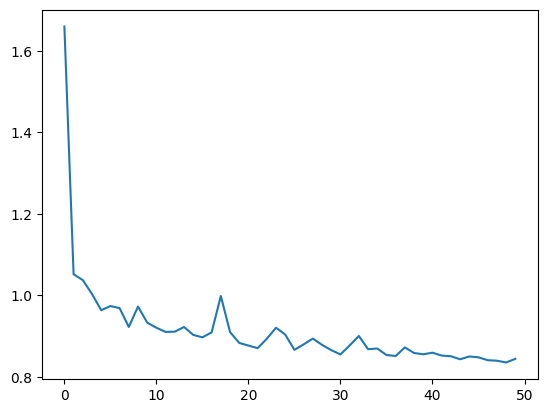

In [137]:
plt.plot(error)

In [138]:
saver.save(sess, 'q2model/q2')

'q2model/q2'

## Validation

In [146]:
#Loading validation set

path = r'/home/mangdy/Desktop'

vx, VX, VX_abs, VX_len = loadfile(path+"/trimmed_noisy_v/",'.wav', 'vx', flag = 1) 

vs, VS, VS_abs, VS_len = loadfile(path+"/trimmed_clean_v/",'.wav', 'vs', flag = 1)

vn, VN, VN_abs, VN_len = loadfile(path+"/gauss_noise_v/",'.wav', 'vn', flag = 1)

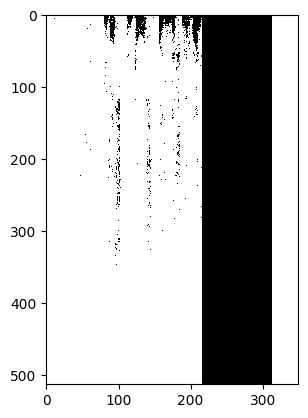

In [149]:
#Getting Binary Masks from S_abs and N_abs
VM = IBM(VS_abs, VN_abs)
plt.imshow(VM[0], cmap='binary', interpolation='none')
plt.show()

Above plot is ideal IBM

In [150]:
#Init variable to store SNR of validation sets

SNR_Val = np.zeros(310)

Function below calculates the SNR for each of the predicted signals in the validation set. Returns the list of SNRs

In [151]:
def calc_SNR(M_pred, X, s, i):
    M_pred = 1 * (M_pred > 0.5)
    M_pred = M_pred.T
    S_pred = M_pred * X
    s_pred = librosa.istft(S_pred, win_length = 1024, hop_length = 512)
    
    nlen = min(len(s), len(s_pred))
    SNR = 10*math.log10((np.sum(s[:nlen]**2))/(np.sum((s[:nlen] - s_pred[:nlen])**2)))
    
    return SNR

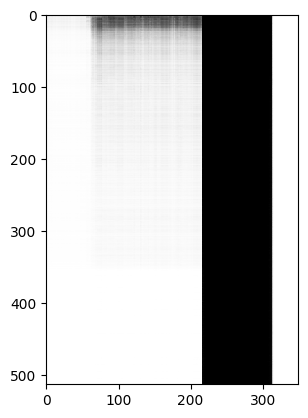

In [157]:
#Getting predictions for all validation sets
for i in range(30):
    epoch_x = np.zeros((1, VX_abs[i].shape[1], VX_abs[i].shape[0]))
    epoch_y = np.zeros((1, VX_abs[i].shape[1], VX_abs[i].shape[0]))
    
    epoch_x[0,:,:] = VX_abs[i].T
    epoch_y[0,:,:] = VS_abs[i].T
    
    VM_pred, val_loss = sess.run([fin_out, cost], feed_dict = {q2_x:epoch_x, q2_y:epoch_y, seq_len : np.array([VX_len[i]]), keep_pr:1})
    if(i==0):
        plt.imshow(VM_pred[0].T, cmap='binary', interpolation='none')
        plt.show()


    SNR_Val[i] = calc_SNR(VM_pred[0,:VX_len[i],:], VX_abs[i], vs[i], i)

Above plot is predicted IBM

In [154]:
#Calculating mean SNR
print(np.mean(SNR_Val))

-0.0341245123002257


## Testing

In [158]:
#Loading test set

path = r'/home/mangdy/Desktop/'

n_file = 10

tex, TEX, TEX_abs, TEX_len = loadfile(path+"/trimmed_noisy_test/",'.wav', 'tex', flag = 1) 

Function below writes out predicted test signals.

In [159]:
import soundfile as sf

In [160]:
def test_SNR(M_pred, X, i):
    M_pred = 1 * (M_pred > 0.5)
    M_pred = M_pred.T
    S_pred = M_pred * X
    s_pred = librosa.istft(S_pred, win_length = 1024, hop_length = 512)
    sf.write(path+'/trimmed_test_output/' + str(i) + '.wav',s_pred,sr)
    

Getting prediction for the test set and storing them.

In [165]:
#Getting predictions for all test sets
for i in range(len(TEX_abs)):
    epoch_x = np.zeros((1, TEX_abs[i].shape[1], TEX_abs[i].shape[0]))
    epoch_y = np.zeros((1, TEX_abs[i].shape[1], TEX_abs[i].shape[0]))
    
    epoch_x[0,:,:] = TEX_abs[i].T
    
    TEM_pred= sess.run(fin_out, feed_dict = {q2_x:epoch_x, seq_len : np.array([TEX_len[i]]), keep_pr: 1})
    
    test_SNR(TEM_pred[0,:TEX_len[i],:], TEX_abs[i], i)
    

The following snippet plots spectrograms for the original clean signal and the recovered clean signal from the network

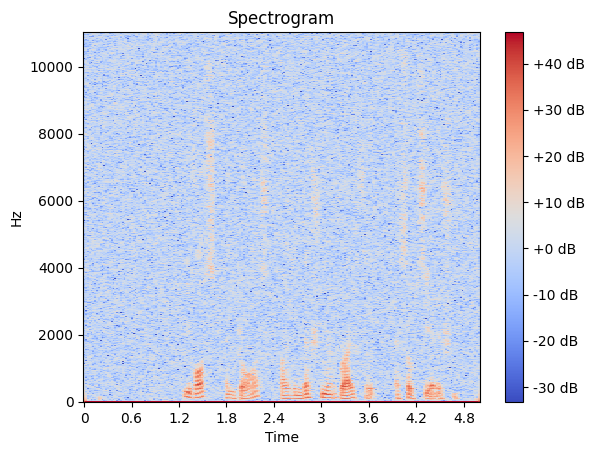

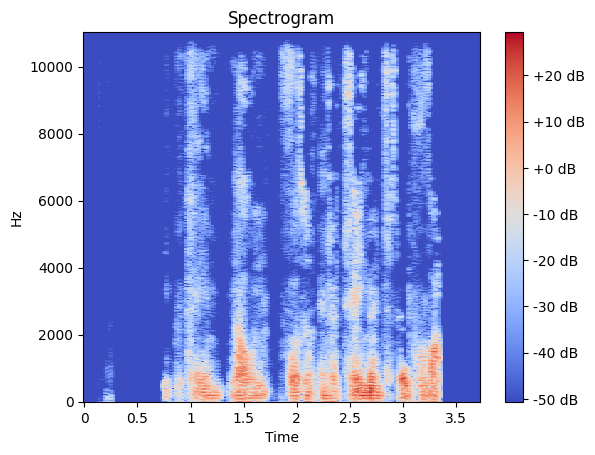

In [163]:
test_file=r"/home/mangdy/Desktop/trimmed_noisy_test/1.wav"
test, sr = librosa.load(test_file)

stft = librosa.stft(test)

# Convert power spectrogram to decibels (dB)
spec = librosa.amplitude_to_db(abs(stft))

# Plot spectrogram
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

recovered_file=r"/home/mangdy/Desktop/trimmed_test_output/1.wav"
recovered, sr = librosa.load(recovered_file)
stft = librosa.stft(recovered)

# Convert power spectrogram to decibels (dB)
spec = librosa.amplitude_to_db(abs(stft))

# Plot spectrogram
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()



First plot corresponds to clean signal and second is the recovered clean signal

In [ ]:
sess.close()